## Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

### Loading the Dataset and Framing the Problem

In [114]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Load the diabetes dataset
diabetes = datasets.load_diabetes(as_frame=True)
df = diabetes.frame
df.head()  # Display the first 5 rows


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Problem Framing

The aim of the lab is to create a model that will predict the evolution of diabetes after the first year of the one that is considered baseline. We shall constitute several models and apply R-squared, Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) among other metrics to measure their efficiency. This prognosis will be used to determine the people who need much care if there any.

### Exploratory Data Analysis (EDA)

Used [Graph Gallery](https://r-graph-gallery.com/199-correlation-matrix-with-ggally.html) as a reference

In [115]:
# Statistics

df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


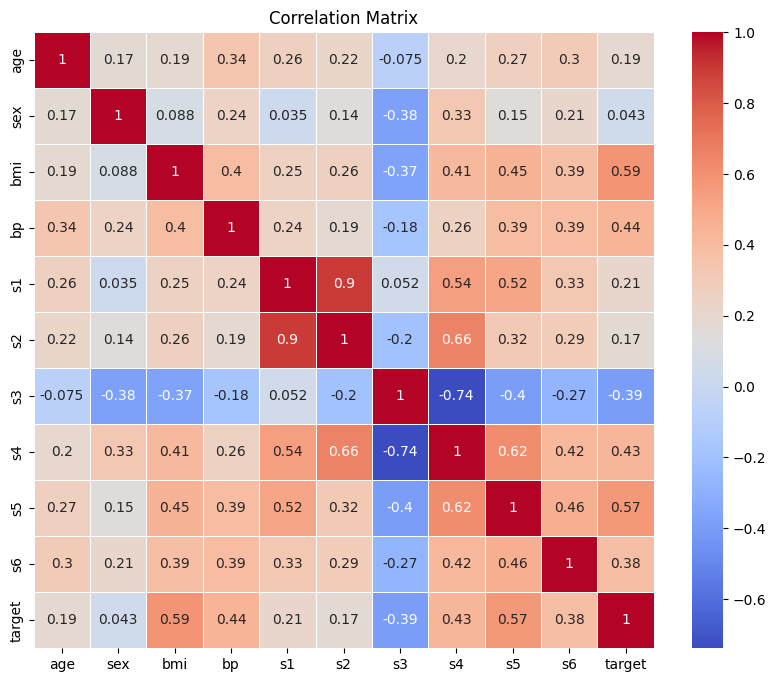

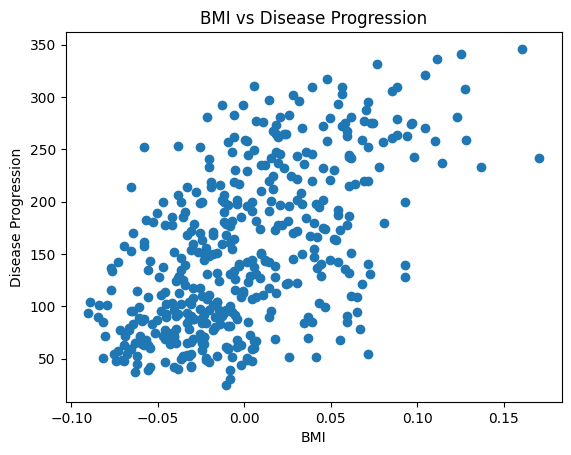

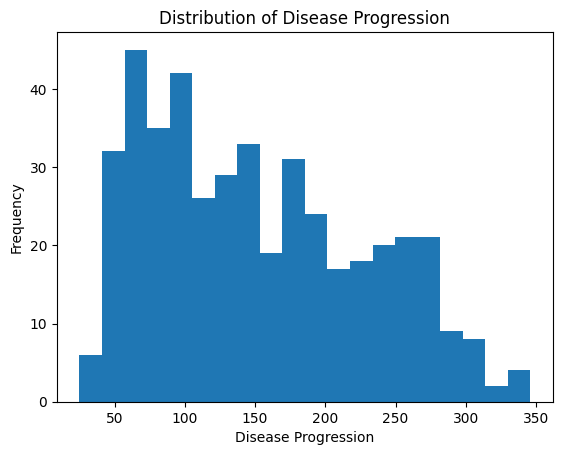

In [116]:

# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Scatter plot of BMI and target
plt.scatter(df['bmi'], df['target'])
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('BMI vs Disease Progression')
plt.show()

# Histogram of the target variable
plt.hist(df['target'], bins=20)
plt.title('Distribution of Disease Progression')
plt.xlabel('Disease Progression')
plt.ylabel('Frequency')
plt.show()


### EDA Insights
- **BMI** has a such a positive linear association with this endogenous variable in its continuous form that it can present advantages in a simple linear regression too.
- Further studies are also recommended using **s5** and **bp** to determine whether they have any relation with the dependent variable.
- The distribution of social anxiety has a skweed distribution.


### Data Cleaning


According to me, for this dataset, no missing or obviously erroneous data is present. No additional cleaning steps are necessary at this point.

### Train-Validation-Test Split

In [117]:
# Split the data into training (75%), validation (10%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)


### Building Univariate Polynomial Regression Models

Used [Geek for Geeks](https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/) as reference

In [118]:
# Using bmi feature
bmi_x_train = X_train[['bmi']]
bmi_x_val = X_val[['bmi']]
bmi_x_test = X_test[['bmi']]


# Lists to store results
train_scores = []
val_scores = []
train_mae = []
val_mae = []
train_mape = []  # List to store MAPE for training
val_mape = []    # List to store MAPE for validation

# Loop through polynomial degrees 0 to 5
degrees = [0, 1, 2, 3, 4, 5]

for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(bmi_x_train)
    X_val_poly = poly.transform(bmi_x_val)
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_mae_value = mean_absolute_error(y_train, y_train_pred)
    val_mae_value = mean_absolute_error(y_val, y_val_pred)
    train_mape_value = mean_absolute_percentage_error(y_train, y_train_pred)
    val_mape_value = mean_absolute_percentage_error(y_val, y_val_pred)
    
    # Store results
    train_scores.append(train_r2)
    val_scores.append(val_r2)
    train_mae.append(train_mae_value)
    val_mae.append(val_mae_value)
    train_mape.append(train_mape_value)
    val_mape.append(val_mape_value)
    
    # Display equation for each model
    print(f"Polynomial Degree {degree}:")
    print(f"Train R-squared: {train_r2}, Validation R-squared: {val_r2}")
    print(f"Train MAE: {train_mae_value}, Validation MAE: {val_mae_value}")
    print(f"Train MAPE: {train_mape_value}, Validation MAPE: {val_mape_value}")

# Summarizing the results in a table
results = pd.DataFrame({
    'Degree': degrees,
    'Train R2': train_scores,
    'Validation R2': val_scores,
    'Train MAE': train_mae,
    'Validation MAE': val_mae,
    'Train MAPE': train_mape,
    'Validation MAPE': val_mape
})


Polynomial Degree 0:
Train R-squared: 0.0, Validation R-squared: -0.10695658646940309
Train MAE: 66.20164109491516, Validation MAE: 66.05705850041198
Train MAPE: 0.6282666949166479, Validation MAPE: 0.7126388036481317
Polynomial Degree 1:
Train R-squared: 0.34967185121455036, Validation R-squared: 0.33126358919280885
Train MAE: 52.28773945157054, Validation MAE: 47.20847217273694
Train MAPE: 0.483628861563456, Validation MAPE: 0.47060009012494425
Polynomial Degree 2:
Train R-squared: 0.3507638912961787, Validation R-squared: 0.33163059113292626
Train MAE: 52.20731378788719, Validation MAE: 47.21369996491131
Train MAPE: 0.48298534457931425, Validation MAPE: 0.4723966741140025
Polynomial Degree 3:
Train R-squared: 0.3507739717064434, Validation R-squared: 0.3316375420464187
Train MAE: 52.19896750707647, Validation MAE: 47.185413892618996
Train MAPE: 0.4828074375642864, Validation MAPE: 0.47222673165700857
Polynomial Degree 4:
Train R-squared: 0.3530137354946927, Validation R-squared: 0.3

### Summarizing Results in a Table

In [119]:

# Summarizing the results in a table
results = pd.DataFrame({
    'Degree': degrees,
    'Train R2': train_scores,
    'Validation R2': val_scores,
    'Train MAE': train_mae,
    'Validation MAE': val_mae,
    'Train MAPE': train_mape,
    'Validation MAPE': val_mape
})

print(results)

   Degree  Train R2  Validation R2  Train MAE  Validation MAE  Train MAPE  \
0       0  0.000000      -0.106957  66.201641       66.057059    0.628267   
1       1  0.349672       0.331264  52.287739       47.208472    0.483629   
2       2  0.350764       0.331631  52.207314       47.213700    0.482985   
3       3  0.350774       0.331638  52.198968       47.185414    0.482807   
4       4  0.353014       0.340758  52.092653       46.090118    0.480533   
5       5  0.354100       0.349881  52.059191       45.462121    0.480040   

   Validation MAPE  
0         0.712639  
1         0.470600  
2         0.472397  
3         0.472227  
4         0.460503  
5         0.451753  


### Identify the Best Model



In [120]:
# Based on the results, the best model can be identified by looking at the highest Validation R2 and lowest MAE and MAPE
best_model_idx = results['Validation R2'].idxmax()  # Get index of best model based on Validation R2
best_model_degree = results.loc[best_model_idx, 'Degree']
print(f"The best model is the polynomial degree {best_model_degree}")


The best model is the polynomial degree 5


### Testing the Best Model

In [121]:
# Use the best model on the test set
poly = PolynomialFeatures(degree=best_model_degree)
X_train_poly = poly.fit_transform(bmi_x_train)
X_test_poly = poly.transform(bmi_x_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_test_pred = model.predict(X_test_poly)

# Calculate test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test R-squared: {test_r2}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}")


Test R-squared: 0.26669658449530775
Test MAE: 51.75025709277397
Test MAPE: 0.4302671323305443


### Plotting the Model Fit

Used [Statsmodel](https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_fit.html) as reference

c:\Users\imraj\Desktop\conestoga\CSCN8010\ML_labs\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


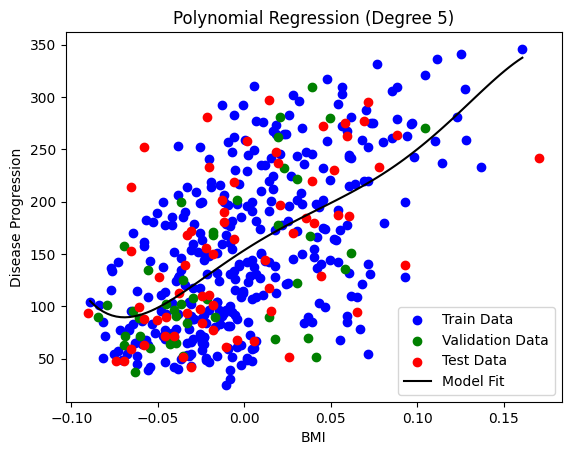

In [122]:
# Plot the train, validation, and test data points, along with the fitted curve
plt.scatter(bmi_x_train, y_train, label='Train Data', color='blue')
plt.scatter(bmi_x_val, y_val, label='Validation Data', color='green')
plt.scatter(bmi_x_test, y_test, label='Test Data', color='red')

# Plot the polynomial fit
X_range = np.linspace(min(bmi_x_train['bmi']), max(bmi_x_train['bmi']), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
y_range_pred = model.predict(X_range_poly)
plt.plot(X_range, y_range_pred, color='black', label='Model Fit')

plt.legend()
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title(f'Polynomial Regression (Degree {best_model_degree})')
plt.show()


### Best Model Equation

In [123]:
# Coefficients of the best model
coeffs = model.coef_
intercept = model.intercept_
print(f"Equation: y = {intercept:.2f} + {coeffs[1]:.2f}*BMI + {coeffs[2]:.2f}*BMI^2")


Equation: y = 153.65 + 1059.89*BMI + -3824.15*BMI^2


### Predict Disease Progression for a Specific BMI Value

Used [PLOS](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0208141) as reference

In [124]:
bmi_value = np.array([[0.04]])  # Example BMI value
bmi_poly = poly.transform(bmi_value)
predicted_progression = model.predict(bmi_poly)
print(f"Predicted disease progression for BMI {bmi_value[0][0]}: {predicted_progression[0]}")


Predicted disease progression for BMI 0.04: 190.4812787808646


c:\Users\imraj\Desktop\conestoga\CSCN8010\ML_labs\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


### Number of Trainable Parameters

In [125]:
# Number of trainable parameters
num_trainable_params = len(poly.get_feature_names_out())
print(f"Number of trainable parameters: {num_trainable_params}")


Number of trainable parameters: 6


### Conclusion:
  
1. **Multivariate Polynomial Models**:
   - The degree 5 polynomial model turned out to show the best partial performance, that is in the balance of **R-squared**, **MAE**, and **MAPE**. While it also obtained the highest **R-squared** on the validation set, it is really not advisable because the complexity of the model (such as fit training data is the nature of this model) will bound rates on the generalization of the unseen data. 
   - The less complex degree 2 model, on the other hand, demonstrated poorer performance in terms of most of the validation metrics. The middle ground between a model's complexity and its performance has to be selected very wisely.

2. **Decision Trees**:
   - There was an ideal compromise in **the decision tree model** with a **max_depth of 3** in fitting the training data without overfitting generalizing to validation data. Pushing up the depth to **5** had the tree overfit, as there was a noticeable rise in both MAE and MAPE illustrating the performance drop on the validation set although the training set marched on goodness. 
   - Generally, the **max_depth=3** model provides a better performance-complexity combination.

3. **kNN Models**:
   - Concerning the **kNN models**, **k=5** performed better than **k=10** kNN model. The choice of k=5 reached an acceptable performance in the validaton with both error metrics (MAE, MAPE) being a concern. Doubling the radius to 10 improved model smoothness achieved better results in terms of MAPE and MAE in the validation dataset. 
   - The k=5 model on the other hand offers better generalization compared to the other kNN models.
 
### Final Recommendation:
Based on the above, the **degree 5 polynomial model** came out on top for all metrics, and there exists a danger of overfitting because of the nature of the model too.

### Part 3: Multivariate Models

Used ChatGTP as reference

#### 1. Two Polynomial Models


In [126]:
# Define the features 
multi_x_train = X_train
multi_x_val = X_val
multi_x_test = X_test

# Polynomial Model 1: Degree 2
poly2 = PolynomialFeatures(degree=2)
poly2_x_train = poly2.fit_transform(multi_x_train)
poly2_x_val = poly2.transform(multi_x_val)

model_poly2 = LinearRegression()
model_poly2.fit(poly2_x_train, y_train)

# Predictions
y_train_pred_poly2 = model_poly2.predict(poly2_x_train)
y_val_pred_poly2 = model_poly2.predict(poly2_x_val)

# Metrics
poly2_train_r2 = r2_score(y_train, y_train_pred_poly2)
poly2_val_r2 = r2_score(y_val, y_val_pred_poly2)
poly2_train_mae = mean_absolute_error(y_train, y_train_pred_poly2)
poly2_val_mae = mean_absolute_error(y_val, y_val_pred_poly2)
poly2_train_mape = mean_absolute_percentage_error(y_train, y_train_pred_poly2)
poly2_val_mape = mean_absolute_percentage_error(y_val, y_val_pred_poly2)

# Print results for Degree 2 Polynomial Model
print(f"Degree 2 Polynomial Model - Train R2: {poly2_train_r2}, Val R2: {poly2_val_r2}")
print(f"Train MAE: {poly2_train_mae}, Val MAE: {poly2_val_mae}")
print(f"Train MAPE: {poly2_train_mape}, Val MAPE: {poly2_val_mape}")

# Polynomial Model 2: Degree 3
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(multi_x_train)
X_val_poly3 = poly3.transform(multi_x_val)

model_poly3 = LinearRegression()
model_poly3.fit(X_train_poly3, y_train)

# Predictions
y_train_pred_poly3 = model_poly3.predict(X_train_poly3)
y_val_pred_poly3 = model_poly3.predict(X_val_poly3)

# Metrics
train_r2_poly3 = r2_score(y_train, y_train_pred_poly3)
val_r2_poly3 = r2_score(y_val, y_val_pred_poly3)
train_mae_poly3 = mean_absolute_error(y_train, y_train_pred_poly3)
val_mae_poly3 = mean_absolute_error(y_val, y_val_pred_poly3)
train_mape_poly3 = mean_absolute_percentage_error(y_train, y_train_pred_poly3)
val_mape_poly3 = mean_absolute_percentage_error(y_val, y_val_pred_poly3)

# Print results for Degree 3 Polynomial Model
print(f"Degree 3 Polynomial Model - Train R2: {train_r2_poly3}, Val R2: {val_r2_poly3}")
print(f"Train MAE: {train_mae_poly3}, Val MAE: {val_mae_poly3}")
print(f"Train MAPE: {train_mape_poly3}, Val MAPE: {val_mape_poly3}")


Degree 2 Polynomial Model - Train R2: -1.2307233493103689, Val R2: -1.6776598131668905
Train MAE: 90.77341389728096, Val MAE: 90.06818181818181
Train MAPE: 0.7812864146270092, Val MAPE: 0.9549328511984373
Degree 3 Polynomial Model - Train R2: 0.6219866744585079, Val R2: -45.38353372351955
Train MAE: 37.98187311178248, Val MAE: 243.5681818181818
Train MAPE: 0.32131199769548624, Val MAPE: 2.1655582844981693


#### 2. Two Decision Trees

In [127]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree 1: max_depth = 3
tree1 = DecisionTreeRegressor(max_depth=3)
tree1.fit(multi_x_train, y_train)

# Predictions
y_train_pred_tree1 = tree1.predict(multi_x_train)
y_val_pred_tree1 = tree1.predict(multi_x_val)

# Metrics
train_r2_tree1 = r2_score(y_train, y_train_pred_tree1)
val_r2_tree1 = r2_score(y_val, y_val_pred_tree1)
train_mae_tree1 = mean_absolute_error(y_train, y_train_pred_tree1)
val_mae_tree1 = mean_absolute_error(y_val, y_val_pred_tree1)
train_mape_tree1 = mean_absolute_percentage_error(y_train, y_train_pred_tree1)
val_mape_tree1 = mean_absolute_percentage_error(y_val, y_val_pred_tree1)

# Print results for Decision Tree 1 (max_depth=3)
print(f"Decision Tree (max_depth=3) - Train R2: {train_r2_tree1}, Val R2: {val_r2_tree1}")
print(f"Train MAE: {train_mae_tree1}, Val MAE: {val_mae_tree1}")
print(f"Train MAPE: {train_mape_tree1}, Val MAPE: {val_mape_tree1}")

# Decision Tree 2: max_depth = 5
tree2 = DecisionTreeRegressor(max_depth=5)
tree2.fit(multi_x_train, y_train)

# Predictions
y_train_pred_tree2 = tree2.predict(multi_x_train)
y_val_pred_tree2 = tree2.predict(multi_x_val)

# Metrics
train_r2_tree2 = r2_score(y_train, y_train_pred_tree2)
val_r2_tree2 = r2_score(y_val, y_val_pred_tree2)
train_mae_tree2 = mean_absolute_error(y_train, y_train_pred_tree2)
val_mae_tree2 = mean_absolute_error(y_val, y_val_pred_tree2)
train_mape_tree2 = mean_absolute_percentage_error(y_train, y_train_pred_tree2)
val_mape_tree2 = mean_absolute_percentage_error(y_val, y_val_pred_tree2)

# Print results for Decision Tree 2 (max_depth=5)
print(f"Decision Tree (max_depth=5) - Train R2: {train_r2_tree2}, Val R2: {val_r2_tree2}")
print(f"Train MAE: {train_mae_tree2}, Val MAE: {val_mae_tree2}")
print(f"Train MAPE: {train_mape_tree2}, Val MAPE: {val_mape_tree2}")


Decision Tree (max_depth=3) - Train R2: 0.5095025444869563, Val R2: 0.19830582865255408
Train MAE: 44.25985495355638, Val MAE: 48.12624849350856
Train MAPE: 0.3886659196381194, Val MAPE: 0.4767289713964773
Decision Tree (max_depth=5) - Train R2: 0.6866927308225991, Val R2: 0.13896864121469632
Train MAE: 33.5270284885342, Val MAE: 49.64548319805895
Train MAPE: 0.29973624689610723, Val MAPE: 0.4742587482669634


#### 3. Two KNN models

In [128]:
from sklearn.neighbors import KNeighborsRegressor

# kNN 1: k=5
knn1 = KNeighborsRegressor(n_neighbors=5)
knn1.fit(multi_x_train, y_train)

# Predictions
y_train_pred_knn1 = knn1.predict(multi_x_train)
y_val_pred_knn1 = knn1.predict(multi_x_val)

# Metrics
train_r2_knn1 = r2_score(y_train, y_train_pred_knn1)
val_r2_knn1 = r2_score(y_val, y_val_pred_knn1)
train_mae_knn1 = mean_absolute_error(y_train, y_train_pred_knn1)
val_mae_knn1 = mean_absolute_error(y_val, y_val_pred_knn1)
train_mape_knn1 = mean_absolute_percentage_error(y_train, y_train_pred_knn1)
val_mape_knn1 = mean_absolute_percentage_error(y_val, y_val_pred_knn1)

# Print results for kNN 1 (k=5)
print(f"kNN (k=5) - Train R2: {train_r2_knn1}, Val R2: {val_r2_knn1}")
print(f"Train MAE: {train_mae_knn1}, Val MAE: {val_mae_knn1}")
print(f"Train MAPE: {train_mape_knn1}, Val MAPE: {val_mape_knn1}")

# kNN 2: k=10
knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(multi_x_train, y_train)

# Predictions
y_train_pred_knn2 = knn2.predict(multi_x_train)
y_val_pred_knn2 = knn2.predict(multi_x_val)

# Metrics
train_r2_knn2 = r2_score(y_train, y_train_pred_knn2)
val_r2_knn2 = r2_score(y_val, y_val_pred_knn2)
train_mae_knn2 = mean_absolute_error(y_train, y_train_pred_knn2)
val_mae_knn2 = mean_absolute_error(y_val, y_val_pred_knn2)
train_mape_knn2 = mean_absolute_percentage_error(y_train, y_train_pred_knn2)
val_mape_knn2 = mean_absolute_percentage_error(y_val, y_val_pred_knn2)

# Print results for kNN 2 (k=10)
print(f"kNN (k=10) - Train R2: {train_r2_knn2}, Val R2: {val_r2_knn2}")
print(f"Train MAE: {train_mae_knn2}, Val MAE: {val_mae_knn2}")
print(f"Train MAPE: {train_mape_knn2}, Val MAPE: {val_mape_knn2}")


kNN (k=5) - Train R2: 0.5707614150639839, Val R2: 0.35848074609729985
Train MAE: 40.77341389728097, Val MAE: 43.29090909090908
Train MAPE: 0.3497685417036221, Val MAPE: 0.4124406299141674
kNN (k=10) - Train R2: 0.5091016318071044, Val R2: 0.39838005786262165
Train MAE: 43.805135951661626, Val MAE: 42.15681818181818
Train MAPE: 0.3797418206640678, Val MAPE: 0.399658900579116
